## Data Loading

In [117]:
import os
import torch
os.environ["TORCH"] = torch.__version__

import numpy as np
import torch_geometric
import torch_geometric.utils as utils
import networkx as nx

from matplotlib import pyplot as plt

from torch.nn import Linear, ReLU, functional as F, MSELoss
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import TopKPooling

%config InlineBackend.figure_format = 'svg'

In [2]:
dataset = torch.load("./graph_data_decoding_2023.pt")

In [3]:
print('====================')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')

data = dataset[20]  # Get one data point.

print('Some properties of a graph in the dataset:')
print()

print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of node features: {data.num_node_features}')
print(data.y)

Number of graphs: 1000000
Some properties of a graph in the dataset:

Data(x=[5, 4], edge_index=[2, 20], edge_attr=[20, 1], y=[1, 2])
Number of nodes: 5
Number of edges: 20
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4
tensor([[1., 0.]])


In [95]:
num_samples = len(dataset)
train_data = dataset[int(.05 * num_samples):] # 95% training data
test_data = dataset[:int(.05 * num_samples)]  #  5% testing data
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

## Graph Neural Network
I'll start off going for a network based on GCN convolutions as their training time seems to be lowest by a large margin according to [Dwivedi, V. P., Joshi, C. K., Laurent, T., Bengio, Y. & Bresson, X.](https://arxiv.org/abs/2003.00982). I'll use *mean squared loss* for starters with an output shape of (1, 2) to avoid having to transform the labels. Later on I'll probably try transforming the labels to (1, 4) to be able to use *Categorical Cross Entropy*.

3 dense layers seems to lead to overfitting. 3 Convolutional layers seems to have issues with vanishing gradients, perhaps due to ReLU?
Removing the dropout layers instantly leads to overfitting.

Moving to just classifying X seems to have greatly increased accuracy. Hopefully Z will turn out the same way. I can't figure out a good way to TopKPool since some networks apparently contain just a single node. It is possible with $k=1$ and I'd argue that is still valuable since the nodes chosen is a learned parameter and it doesn't meaningfully slow down learning.

In [170]:
from typing import List

NODE_FEATURES = 4

class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        
        self.conv1 = GATConv(NODE_FEATURES, 256)
        self.conv2 = GATConv(256, 128)
        self.topk_pool = TopKPooling(128, ratio=1)
        
        self.dense1 = Linear(128, 1)
        
    
    def forward(self, x, edge_index, batch, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        # x = global_mean_pool(x, batch)
        (x, edge_index, edge_attr, batch, perm, _) = self.topk_pool(x, edge_index, edge_attr, batch)
        
        x = F.dropout(x, p=0.5, training=self.training) # Noise should help during training
        x = self.dense1(x)
        x = x.relu()
        
        # x = F.softmax(x, dim=1)
        return x
    
    def train_batch(self, optimizer, criterion, batch):
        self.train()
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index, batch.batch, batch.edge_attr)
        loss = criterion(out, batch.y[:,0:1])
        loss.backward()
        optimizer.step()
        return loss
    
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index, data.batch, batch.edge_attr)
        pred = torch.round(out)
        test_correct = (pred == data.y[:,0:1]).all(dim=1)
        test_acc = int(test_correct.sum()) / int(pred.size()[0])
        return test_acc

In [171]:
model = GNN()
print(model)

GNN(
  (conv1): GATConv(4, 256, heads=1)
  (conv2): GATConv(256, 128, heads=1)
  (topk_pool): TopKPooling(128, ratio=1, multiplier=1.0)
  (dense1): Linear(in_features=128, out_features=1, bias=True)
)


Epoch: 00 Loss: 0.0604 Acc: 0.9399 Seconds elapsed: 48
Epoch: 01 Loss: 0.0459 Acc: 0.9448 Seconds elapsed: 94
Epoch: 02 Loss: 0.0421 Acc: 0.9482 Seconds elapsed: 139
Epoch: 03 Loss: 0.0394 Acc: 0.9560 Seconds elapsed: 185
Epoch: 04 Loss: 0.0375 Acc: 0.9575 Seconds elapsed: 231
Epoch: 05 Loss: 0.0360 Acc: 0.9580 Seconds elapsed: 277
Epoch: 06 Loss: 0.0353 Acc: 0.9578 Seconds elapsed: 322
Epoch: 07 Loss: 0.0345 Acc: 0.9579 Seconds elapsed: 368
Epoch: 08 Loss: 0.0338 Acc: 0.9607 Seconds elapsed: 414
Epoch: 09 Loss: 0.0334 Acc: 0.9612 Seconds elapsed: 459
Epoch: 10 Loss: 0.0326 Acc: 0.9612 Seconds elapsed: 505
Epoch: 11 Loss: 0.0322 Acc: 0.9618 Seconds elapsed: 554
Epoch: 12 Loss: 0.0316 Acc: 0.9622 Seconds elapsed: 600
Epoch: 13 Loss: 0.0312 Acc: 0.9653 Seconds elapsed: 646
Epoch: 14 Loss: 0.0310 Acc: 0.9636 Seconds elapsed: 691
Epoch: 15 Loss: 0.0307 Acc: 0.9641 Seconds elapsed: 737
Epoch: 16 Loss: 0.0307 Acc: 0.9659 Seconds elapsed: 782
Epoch: 17 Loss: 0.0300 Acc: 0.9664 Seconds elapsed

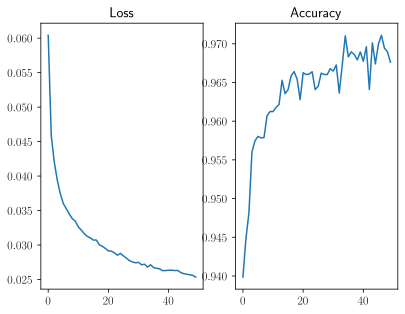

In [172]:
import time

criterion = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015, amsgrad=True)

start_time = time.time()
EPOCHS = 50
losses = np.zeros(EPOCHS)
accs = np.zeros(EPOCHS)
epochs = np.arange(EPOCHS)
for epoch in range(EPOCHS):
    # There are 950 batches for training
    for batch in train_loader:
        loss = model.train_batch(optimizer, criterion, batch)
        losses[epoch] += loss
        
    batches = 0
    for batch in test_loader:
        acc = model.test(batch)
        accs[epoch] += acc
        batches += 1
        
    print(f"Epoch: {epoch:02d} Loss: {losses[epoch]/950:.4f} Acc: {accs[epoch]/50:.4f} Seconds elapsed: {int(time.time() - start_time)}")

losses = losses / 950
accs = accs / 50

plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accs)
plt.title("Accuracy")

plt.show()